In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from gensim.corpora.dictionary import Dictionary

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import dataloader
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ModuleNotFoundError: No module named 'torchtext'

In [6]:
# Read true and fake news datasets
true_news = pd.read_csv('C:\Users\harsh\OneDrive - Texas Tech University\Desktop\Rl\Harshini_US 2 2\Harshini_US 2\Datasets\True.csv')[['text']]
fake_news = pd.read_csv('C:\Users\harsh\OneDrive - Texas Tech University\Desktop\Rl\Harshini_US 2 2\Harshini_US 2\Datasets\Fake.csv')[['text']]

max_sentence_len = 200

def tokenize_and_clean(news, label):
    # remove short text
    news = news.loc[news['text'].str.len() > 1].copy()
    # generate labels for each document
    news['label'] = label
    # taking only first 100 words from each document to semplify this notebook complexity
    news['text'] = news['text'].apply(lambda x: remove_stopwords(x).split()[:max_sentence_len])
    return news

true_news = tokenize_and_clean(true_news, 0)
fake_news = tokenize_and_clean(fake_news, 1)

# merge the two dataframes
dataset = true_news.append(fake_news)
display(dataset)

print(f"There are {len(true_news)} negative class entries and {len(fake_news)} positive class entries - " 
      f"for a total of {len(true_news)+len(fake_news)} entries")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (905517688.py, line 2)

The cell below is generating the dictionary which will be used to convert each word in numbers, the dictiaonrty then represent a mapping of type $word -> tag$. This step is needed as neural network cannot handle alphanumeric input data (of course) and will need to have numnbers in input instead. Each document will be then presented to the network as a list of numbers where each number represent a given word. Hereafter I'm using gensim to create the dictionary, Pytorch also provide some nice tools to handle this, however I tend to use Gensim as I find it a bit more flexible for multiple purposes.

In [ ]:
max_len = max([len(x) for x in dataset['text']])
# Give the list of tokenized document to the Dictionary class whichi will generate the word mapping.
dictionary = Dictionary(documents=dataset['text'])
# convert each document to a tensor containing a list of word tags (numbers)
dataset['doc2idx'] = dataset['text'].apply(lambda _text: F.pad(
                torch.tensor(dictionary.doc2idx(_text)),
                (0, max_len-len(_text))
            ))
# storing the dictionary size
vocab_size = max(dictionary.keys())+1
print(f'Max sentence lenght is: {max_len} - vocab size is: {vocab_size}')

Max sentence lenght is: 200 - vocab size is: 302159


Ok I wanted to just add a wordcloud graph...just because are cool! :)

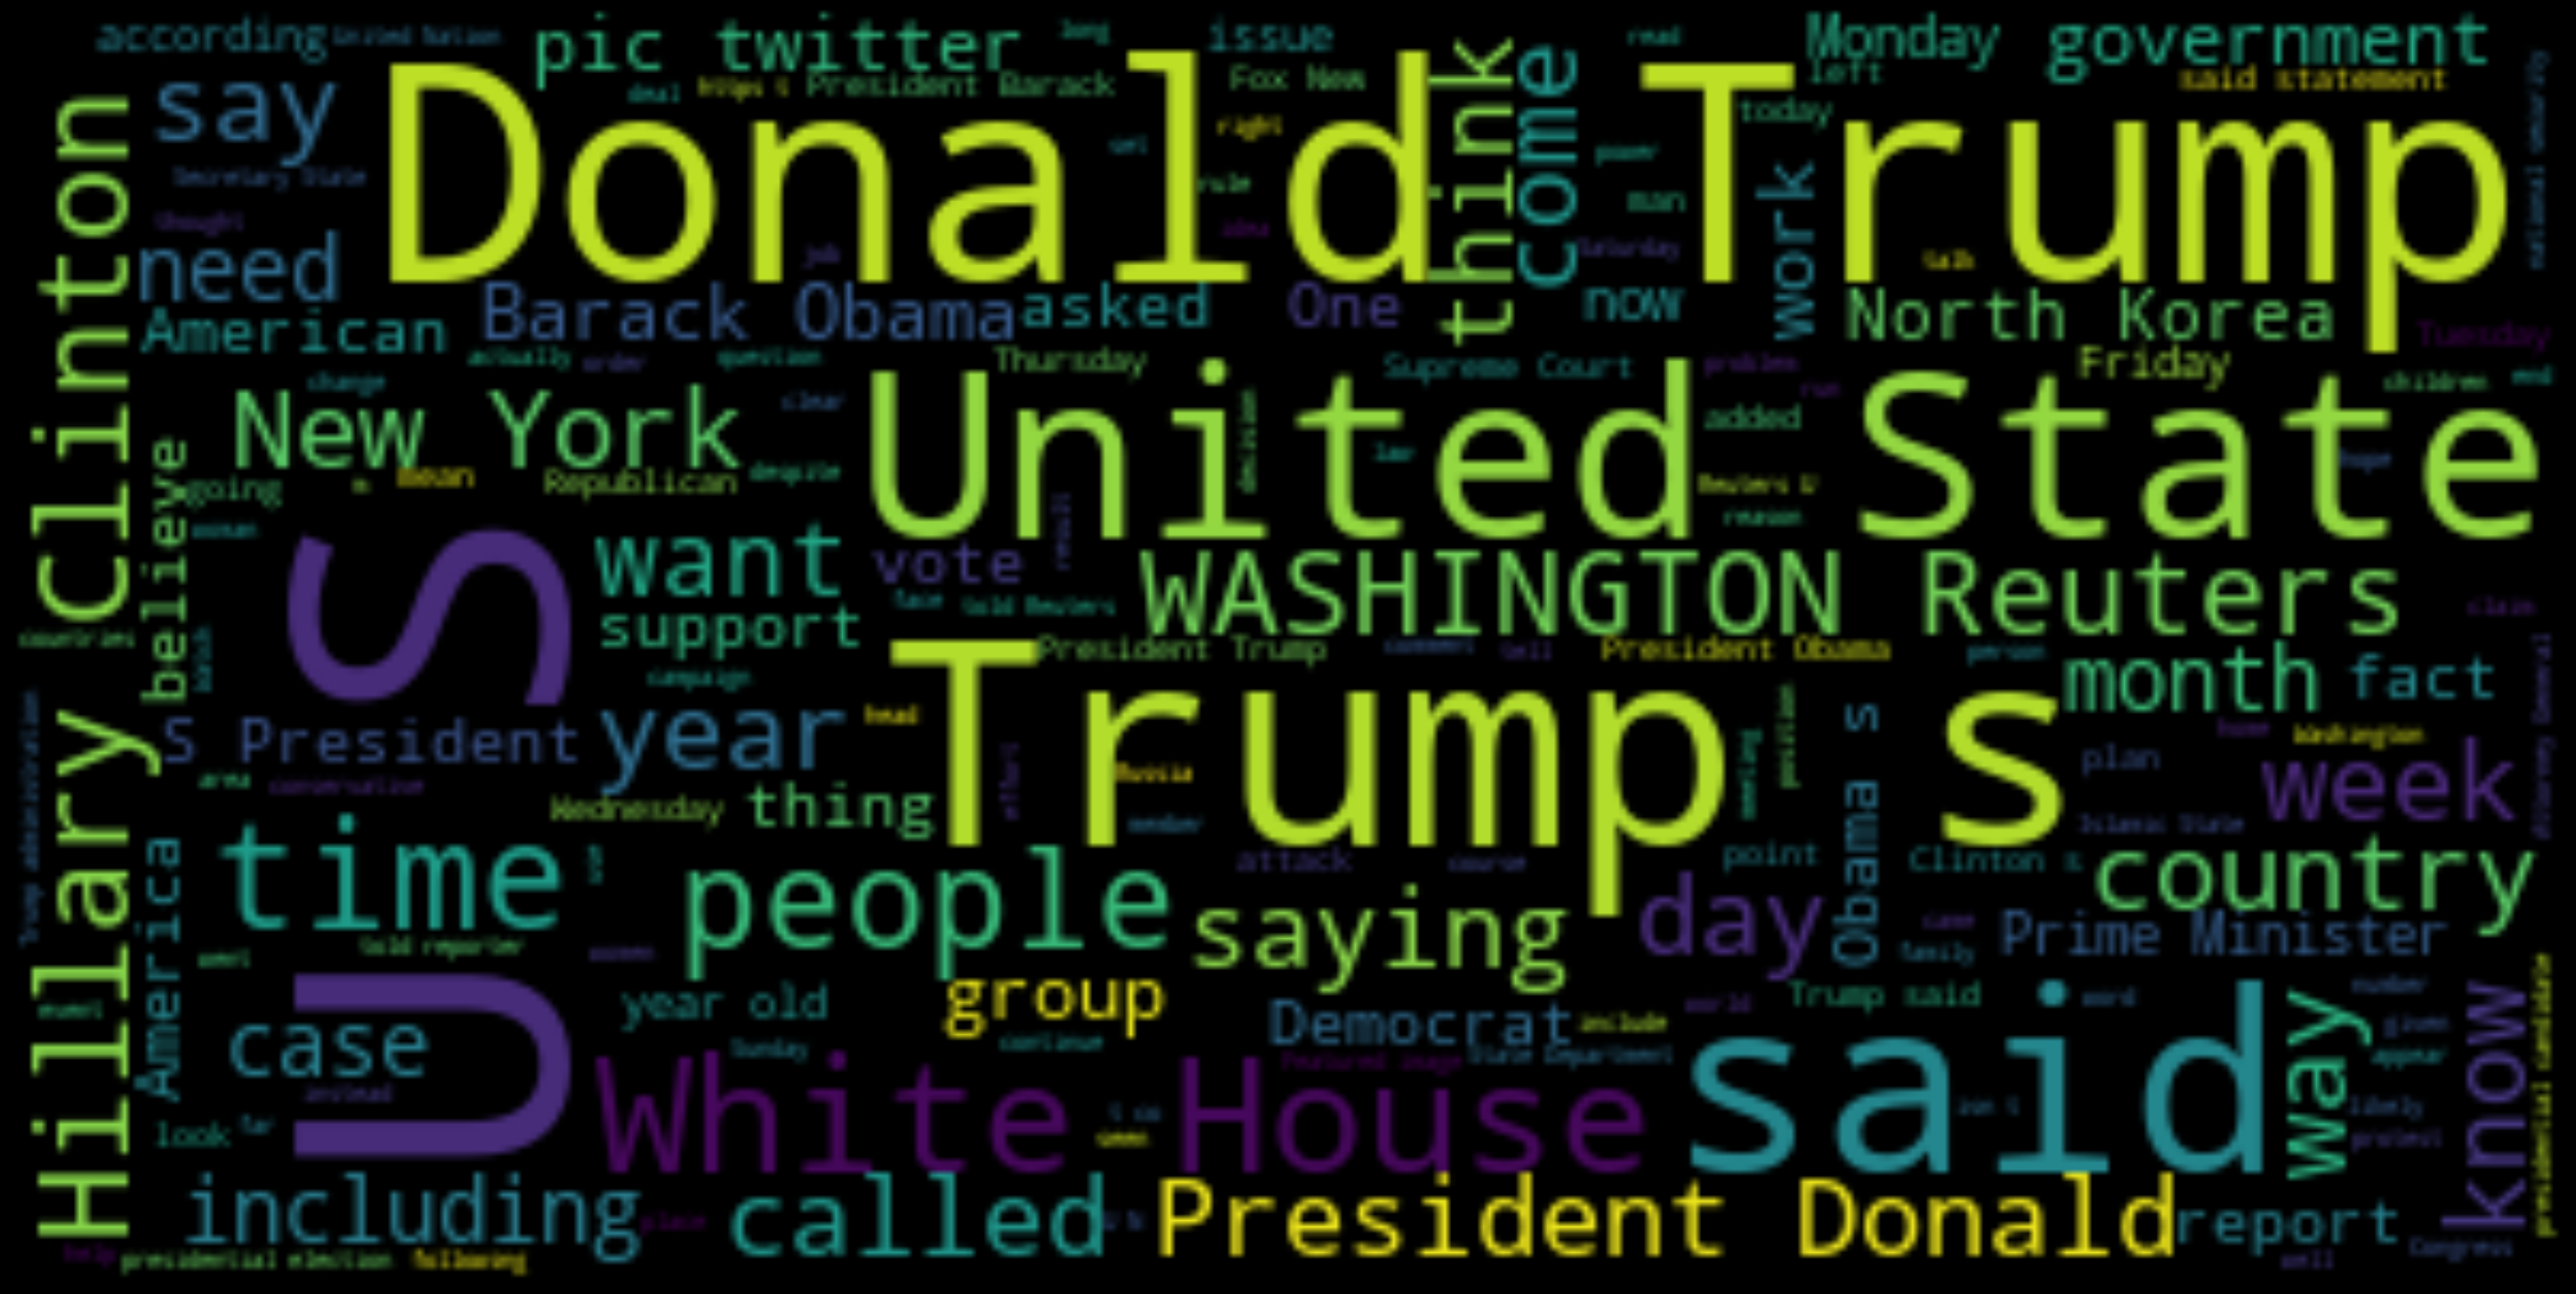

In [ ]:
wordcloud = WordCloud().generate(" ".join(y for x in dataset['text'] for y in x))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

So let's create the data loader we will use to feed our networks, the step is quite simple and use the nice DataLoader class provided by Pytorch. I'm not giving much details here, just something to call out is that I'm selecting only 65% of the whole datast, again this is mainly to reduce the complexity and time needed by this notebook to compute the final results. I can just say always refer to official documentation to have a better idea of what classes are doing ([DataLoader tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html))

In [ ]:
def collate_fn(batch):
    labels, texts = [], []
    for _text, _label in batch:
        labels.append(_label)
        texts.append(_text)
    return torch.tensor(labels, dtype=torch.float32), torch.stack(texts)

reduced_dataset = dataset[:int(len(dataset)*0.65)]
train_ds, val_ds = train_test_split(reduced_dataset[['doc2idx', 'label']], test_size=0.2)
train_loader = dataloader.DataLoader(train_ds.values, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = dataloader.DataLoader(val_ds.values, batch_size=8, shuffle=True, collate_fn=collate_fn)

print(f"Training and validation datasets have respectively {len(train_ds)} and {len(val_ds)} entires")

Training and validation datasets have respectively 23020 and 5756 entires


The functions below are quite "standard" the only thing are reading the batch data provided by the DataLoader class, feeding the data to the network and for the **fit** collecting the results, computing the gradients and updating all the parameters, while the **evaluate** will compute and print some metrics as loss, accuracy and F1 score.

In [ ]:
def evaluate(model, dl, loss_function=F.binary_cross_entropy):
    with torch.no_grad():
        losses, accs, f1s = [], [] , []
        out, labels = torch.tensor([], requires_grad=False), torch.tensor([], requires_grad=False)
        preds = torch.tensor([], requires_grad=False)
        for label, text in dl:
            _out, _preds = model(text)
            out = torch.cat([out, _out])
            preds = torch.cat([preds, _preds])
            labels = torch.cat([labels, label])
        loss = loss_function(out, labels)
        losses.append(loss.item())
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds)

        accs.append(acc)
        f1s.append(f1)

    return np.mean(losses), np.mean(accs), np.mean(f1s), (labels, preds)

In [ ]:
def fit(epochs, lr, model, train, val, loss_function=F.binary_cross_entropy):
    optimizer=torch.optim.Adam(model.parameters() ,lr, weight_decay=1e-5)
    history=[]
    
    for epoch in range(epochs):
        #training phase
        model.train()
        for label, text in train:
            optimizer.zero_grad()
            probs, predictions = model(text)
            loss = loss_function(probs, label)
            loss.backward()
            optimizer.step()
        #Validation phase
        loss, acc, f1, _ = evaluate(model, val, loss_function=loss_function)
        history.append((loss, acc, f1))
        print('Epoch: {}; Loss: {:.6f}; Accuracy: {:.4f}; F1 Score: {:.4f}'.format(
            epoch,loss,acc,f1))
    
    return pd.DataFrame(history, columns=['loss', 'acc', 'f1']) 

In [ ]:
def print_confusion_matrix(model, val, loss_function=F.binary_cross_entropy):
    _, _, _, res = evaluate(dan_model, val_loader, loss_function=loss_function)
    cm = confusion_matrix(res[0], res[1])
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Word Embedding
, Feed Forword

In [ ]:
class DAN(nn.Module):
    def __init__(self,
                 dictionaty_size,
                 d_hiddens=[100],
                 d_embedding=50):
        super(DAN, self).__init__()
        self.__d_hidden = d_hiddens
        # Embedding layer (words->vectors)
        self._embedding_layer = nn.Embedding(dictionaty_size, d_embedding)
        # hiddens batch. normalization 
        self.hiddens_bnorm = [nn.BatchNorm1d(d_hiddens[index-1] if index > 0 else 50)
                        for index in range(len(d_hiddens))]
        # hidden layer
        self.hiddens = [nn.Linear(d_hiddens[index-1] if index > 0 else 50, d_hiddens[index])
                        for index in range(len(d_hiddens))]
        # output layer (probability to be fake)
        self.hout = nn.Linear(d_hiddens[-1], 1)
        
    def forward(self, batch):
        # generate the embedding for each word and represent each document
        # as a matrix and compute the average of each embedding
        # the resulting vecotr will be a representation for the document D
        x = self._embedding_layer(batch.to(torch.int64)).mean(1)
        for layer, norm in zip(self.hiddens, self.hiddens_bnorm):
            # for each layer apply to the input matrix
            x = layer(norm(x))
        # apply output layer
        x = self.hout(x)
        x = torch.sigmoid(x)[:, 0]
        return x, (x>0.5).float()

In [ ]:
dan_model = DAN(vocab_size, d_embedding=50)
history_dan = fit(5, 0.02, dan_model, train_loader, val_loader)

Epoch: 0; Loss: 0.063174; Accuracy: 0.9816; F1 Score: 0.9643
Epoch: 1; Loss: 0.052151; Accuracy: 0.9844; F1 Score: 0.9702
Epoch: 2; Loss: 0.039038; Accuracy: 0.9873; F1 Score: 0.9758
Epoch: 3; Loss: 0.055196; Accuracy: 0.9800; F1 Score: 0.9618
Epoch: 4; Loss: 0.043546; Accuracy: 0.9856; F1 Score: 0.9725


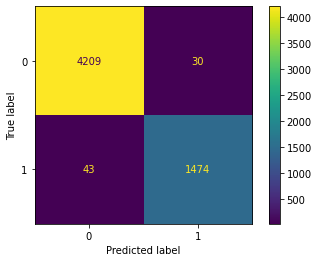

In [ ]:
print_confusion_matrix(dan_model, val_loader)

## Recurrent Neural Network

In [ ]:
class RNN_TC(nn.Module):
    def __init__(self,
                 dictionaty_size,
                 d_hiddens=100,
                 num_layers=1,
                 d_embedding=50):
        super(RNN_TC, self).__init__()
        self.__d_hidden = d_hiddens
        # same thing words to embeddings
        self._embedding_layer = nn.Embedding(dictionaty_size, d_embedding)
        # here the hidden layer is a list of d_hiddens LSTM cells 
        self.hiddens = nn.LSTM(50, d_hiddens, batch_first=True,
                               num_layers=num_layers, dropout=0.2 if num_layers > 1 else 0)
        # Final linear layer to compute the output probability
        self.hout = nn.Linear(d_hiddens, 1)
        
    def forward(self, batch):
        # embedding
        x = self._embedding_layer(batch.to(torch.int64))
        # apply LSTM iterativelly on the embeddings sequence
        x, h = self.hiddens(x)
        # get the last output from the LSTM and pass it through
        # the output linear layer
        x = self.hout(h[0].squeeze())
        x = torch.sigmoid(x)[:, 0]
        return x, (x>0.5).float()

In [ ]:
recurrent_model = RNN_TC(vocab_size, d_embedding=50)
history_rnn = fit(5, 0.02, recurrent_model, train_loader, val_loader)

Epoch: 0; Loss: 0.027559; Accuracy: 0.9934; F1 Score: 0.9876
Epoch: 1; Loss: 0.036000; Accuracy: 0.9908; F1 Score: 0.9824
Epoch: 2; Loss: 0.036614; Accuracy: 0.9969; F1 Score: 0.9941
Epoch: 3; Loss: 0.005478; Accuracy: 0.9988; F1 Score: 0.9977
Epoch: 4; Loss: 0.053283; Accuracy: 0.9891; F1 Score: 0.9796


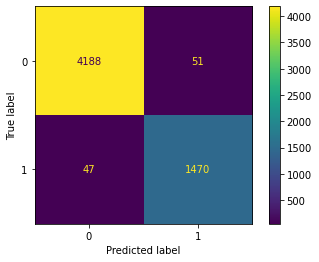

In [ ]:
print_confusion_matrix(recurrent_model, val_loader)

# CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self,
                 dictionaty_size,
                 d_kernels=[3, 4],
                 d_embedding=50,
                 sentence_len=200):
        super(CNN, self).__init__()
        self._n_outchannels = 3
        self.__d_kernels = d_kernels
        # embedding layer
        self._embedding_layer = nn.Embedding(dictionaty_size+1, d_embedding)
        # convolutions filters of size d_kernels
        self.convs = [nn.Conv2d(1, self._n_outchannels, [window_size, d_embedding],
                                padding=(window_size - 1, 0))
                      for window_size in d_kernels]
        # max pool layer
        self.max_pools = [nn.MaxPool1d((sentence_len-window_size+2*(window_size-1))+1) 
                         for window_size in d_kernels]
        # flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        # output layer
        self.hout = nn.Linear(self._n_outchannels*len(d_kernels), 1)
        
    def forward(self, batch):
        # embedding and adding channel layer
        input_batch = self._embedding_layer(batch.to(torch.int64)).unsqueeze(1) 
        xs = []
        # for each couple conv max pool 
        for conv, max_pool in zip(self.convs, self.max_pools):
            # apply convolution 
            x = conv(input_batch)
            # remove size 1 dimension
            x = x.squeeze(-1) 
            # apply max pool 
            x = max_pool(x)
            # append the output to the list of filters output
            xs.append(x)
        # concatenate all filters outputs
        x = torch.cat(xs, 2)
        # create a flat vector which holds all filter-pool outputs
        # and apply last linear layer
        x = self.hout(self.flatten(x))
        x = torch.sigmoid(x)[:, 0]
        return x, (x>0.5).float()

In [ ]:
cnn_model = CNN(vocab_size, sentence_len=max_sentence_len, d_embedding=50)
history_cnn = fit(5, 0.02, cnn_model, train_loader, val_loader)

Epoch: 0; Loss: 0.004090; Accuracy: 0.9983; F1 Score: 0.9967
Epoch: 1; Loss: 0.002075; Accuracy: 0.9991; F1 Score: 0.9984
Epoch: 2; Loss: 0.005002; Accuracy: 0.9986; F1 Score: 0.9974
Epoch: 3; Loss: 0.004221; Accuracy: 0.9986; F1 Score: 0.9974
Epoch: 4; Loss: 0.003832; Accuracy: 0.9983; F1 Score: 0.9967


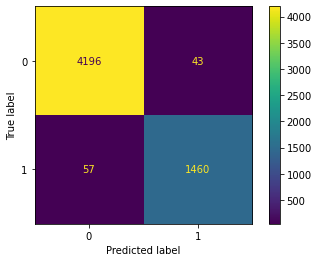

In [ ]:
print_confusion_matrix(cnn_model, val_loader)

# Capsule Network

In [ ]:
class Squash(nn.Module):
    """
    Normalise the lenght of all capsules.
    """
    def __init__(self, epsilon=1e-8):
        super(Squash, self).__init__()
        self.epsilon = epsilon

    def forward(self, s: torch.Tensor):
        """
        The shape of `s` is `[batch_size, n_capsules, n_features]`
        """

        s2 = (s ** 2).sum(dim=-1, keepdims=True)
        return (s2 / (1 + s2)) * (s / torch.sqrt(s2 + self.epsilon))
    
    
class Router(nn.Module):
    """
    Implement digit capsule using dynamic routing.
    """
    def __init__(self, in_caps, out_caps, in_d, out_d, iterations=3):
        super(Router, self).__init__()
        self.in_caps = in_caps
        self.out_caps = out_caps
        self.squash = Squash()
        self.iterations = iterations


        self.weight = nn.Parameter(torch.randn(in_caps, out_caps, in_d, out_d), requires_grad=True)

    def forward(self, u):
        """
        The shape of `u` is `[batch_size, n_capsules, n_features]`.
        These are the capsules from the lower layer.
        """
        # input shapes: [in_caps, out_caps, in_d, out_d] x [batch, in_caps, in_d]
        # output shape [batch, in_caps, out_caps, oud_d]
        # u_hat encode some spatial relationship between the lower level
        # capsule and the higher level capsule.
        u_hat = torch.einsum('ijnm,bin->bijm', self.weight, u)
        # initialise the routing b to 0 (equal probability)
        b = u.new_zeros(u.shape[0], self.in_caps, self.out_caps)

        v = None

        # Iterate
        for i in range(self.iterations):
            # c encode the probabilty that lower level capsule i send 
            # its input to the the higher capsule j
            c = F.softmax(b, dim=-1)
            # similar to regular neurons compute the linear combination 
            # of the u_hat inputs
            # input shapes: [batch, in_caps, out_caps] x [batc, in_caps, out_caps, out_d]
            # output shape: [batch, out_caps, out_d]
            s = torch.einsum('bij,bijm->bjm', c, u_hat)
            # computed capsules outputs. 
            # Please note each capsule is normalised encoding
            # the probability that the capsule j predict the class C
            v = self.squash(s)
            # measure the lower level capsules "agreement"
            # input_shapes: [batch, out_caps, out_d] x [batch, in_caps, out_caps, out_d]
            # output_shape: [batch, in_caps, out_caps]
            a = torch.einsum('bjm,bijm->bij', v, u_hat)
            # update b which will change the probabiliry tensor c
            b = b + a


        return v
    
    
class MarginLoss(nn.Module):
    "Implement the margin loss"
    def __init__(self, *, n_labels, lambda_=0.5, m_positive=0.9, m_negative=0.1):
        super(MarginLoss, self).__init__()

        self.m_negative = m_negative
        self.m_positive = m_positive
        self.lambda_ = lambda_
        self.n_labels = n_labels

    def forward(self, v, labels):
        
        v_norm = torch.sqrt((v ** 2).sum(dim=-1))
        labels = torch.eye(self.n_labels, device=labels.device)[labels.to(int)]
        loss = labels * F.relu(self.m_positive - v_norm) + \
               self.lambda_ * (1.0 - labels) * F.relu(v_norm - self.m_negative)

        return loss.sum(dim=-1).mean()

In [ ]:
class CapsNet(nn.Module):
    def __init__(self,
                 dictionaty_size,
                 kernel_size=9,
                 d_embedding=50,
                 sentence_len=200):
        super(CapsNet, self).__init__()
        # embedding layer
        self._embedding_layer = nn.Embedding(dictionaty_size+1, d_embedding)
        # elu layer
        self.conv_elu = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(kernel_size, d_embedding), stride=1, padding=0)
        # conv layer (features extraction)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(kernel_size, d_embedding), stride=1, padding=0)
        # primary capsule layer
        self.primary_caps = nn.Conv2d(in_channels=32, out_channels=32 * 8, kernel_size=(sentence_len-kernel_size+1, 1),
                                      stride=2, padding=0)
        self.squash = Squash()
        self.relu = nn.ReLU()
        # digit capsules using dynamic routing
        self.digit_capsules = Router(32, 2, 8, 16)
        
    def forward(self, batch):
        # embedding and adding channel layer
        input_batch = self._embedding_layer(batch.to(torch.int64)).unsqueeze(1) 
        gate = torch.mul(F.elu(self.conv_elu(input_batch)), self.conv1(input_batch))
        x = self.primary_caps(gate)
        caps = self.relu(x.view(x.shape[0], 8, 32)).permute(0, 2, 1)
        caps = self.squash(caps)
        caps = self.digit_capsules(caps)
        return caps, (caps**2).sum(dim=-1).argmax(-1)

In [ ]:
capsnet = CapsNet(vocab_size, sentence_len=200, d_embedding=50)
history_caps = fit(5, 0.02, capsnet, train_loader, val_loader, MarginLoss(n_labels=2))

Epoch: 0; Loss: 0.003377; Accuracy: 0.9984; F1 Score: 0.9970
Epoch: 1; Loss: 0.010892; Accuracy: 0.9974; F1 Score: 0.9950
Epoch: 2; Loss: 0.003898; Accuracy: 0.9983; F1 Score: 0.9967
Epoch: 3; Loss: 0.002434; Accuracy: 0.9988; F1 Score: 0.9977
Epoch: 4; Loss: 0.002360; Accuracy: 0.9988; F1 Score: 0.9977


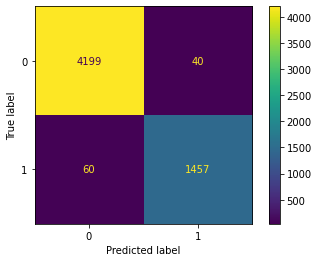

In [ ]:
print_confusion_matrix(capsnet, val_loader, loss_function=MarginLoss(n_labels=2))